<a href="https://colab.research.google.com/github/ShivajiMallela/Deep-learning-with-Tensorflow/blob/main/01_neural_network_regression_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Neural Network Regression with TensorFlow

There are various definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis), but for my learning purposes, I'll simplify it as: predicting a number.

For example, I might want to:
- Estimate the selling price of houses given information about them (such as the number of rooms, size, and number of bathrooms).
- Determine the coordinates of a bounding box for an item in an image.
- Calculate the cost of medical insurance for an individual based on their demographics (age, sex, gender, race).

In this notebook, I'll lay the groundwork for taking a sample of inputs (my data), building a neural network to discover patterns in those inputs, and then making predictions (in the form of numbers) based on those inputs.

## What I'll cover

Specifically, I'll explore the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modeling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (training it to find patterns in my data)
- Evaluating a model
  - Visualizing the model ("visualize, visualize, visualize")
  - Analyzing training curves
  - Comparing predictions to ground truth (using my evaluation metrics)
- Saving a model (so I can reuse it later)
- Loading a model

I'll go through each step in detail.



In [1]:
import tensorflow as tf
print(tf.__version__)

import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

2.15.0
Notebook last run (end-to-end): 2024-06-21 17:19:55.013724


In [2]:
import keras
print(keras.__version__)

2.15.0


# Creating data to view and fit

Since we're working on a **regression problem** (predicting a number) let's create some linear data (a straight line) to model.

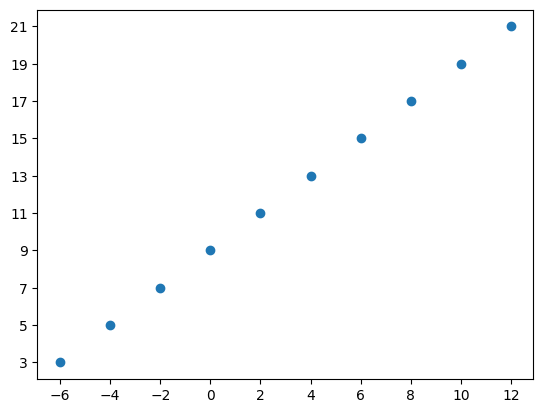

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create features
X = np.array([-6.0, -4.0, -2.0, 0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])

# Create labels
y = np.array([3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0])

# Visualize it
plt.scatter(X, y)
plt.xticks(X)
plt.yticks(y);

Before I do any modeling, I need to calculate the pattern between `X` and `y`.

For example, let's say I want to determine the `y` value based on this data if `X` is 17.0.

Or how about if `X` is -10.0?

This kind of pattern discovery is the essence of what I'll be building neural networks to do for me.


# Regression Input Shapes and Output Shapes

One of the most important concepts when working with neural networks is understanding the input and output shapes.

The **input shape** refers to the shape of the data that goes into the model.

The **output shape** refers to the shape of the data that you want to come out of the model.

These shapes will vary depending on the problem we're working on.

Neural networks take in numbers and output numbers. These numbers are usually represented as tensors (or arrays).

Previously, I created data using NumPy arrays, but I could do the same with tensors.


In [4]:
# Example input and output shapes of a regression model
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([908960])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([908960], dtype=int32)>)

In [5]:
house_info.shape, house_price.shape

(TensorShape([3]), TensorShape([1]))

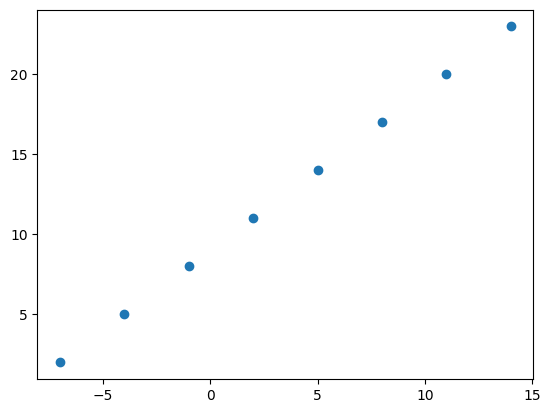

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create features
X = tf.constant([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = tf.constant([2.0, 5.0, 8.0, 11.0, 14.0, 17.0, 20.0, 23.0])

# plot X and y
plt.scatter(X,y);

Our goal here is to predict `y` by using value of `X`

So our **input** will be `X` and our **output** will be `y`.

Knowing this, what do you think our input and output shapes will be?

Let's take a look.

In [7]:
# Take a single example of X
input_shape = X[0].shape

# Take a single example of y
output_shape = y[0].shape

input_shape, output_shape # these are both scalars (no shape)

(TensorShape([]), TensorShape([]))

In my case, I'm trying to build a model to predict the pattern between `X[0]` being `-7.0` and `y[0]` being `3.0`.

So now I have my answer: I'm trying to use one `X` value to predict one `y` value.

I might be thinking, "this seems pretty complicated for just predicting a straight line...".

But the concepts that are covering here, the concepts of input and output shapes for a model, are fundamental.

In fact, these are probably two of the things that we spend the most time on when working with neural networks: **making sure my inputs and outputs are in the correct shape**.


# Steps in Modeling with TensorFlow

Now that I know what data I have and understand the input and output shapes, let's build a neural network to model it.

In TensorFlow, there are typically three fundamental steps to creating and training a model:

1. **Creating a model** - assembling the layers of a neural network either by using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), or by importing a previously built model (known as transfer learning).
2. **Compiling a model** - defining how the model's performance should be measured (loss/metrics) and specifying how it should improve (optimizer).
3. **Fitting a model** - training the model to find patterns in the data (how `X` relates to `y`).

Let's see these steps in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for my regression data. Then I'll walk through each step.

> **Note:** From the version [TensorFlow 2.7.0](https://github.com/tensorflow/tensorflow/releases/tag/v2.7.0)+, the `fit()` function no longer automatically upscales input data from `(batch_size, )` to `(batch_size, 1)`. To address this, we need to expand the dimension of the input data using `tf.expand_dims(input_data, axis=-1)`.
>
> This means instead of using `model.fit(X, y, epochs=5)`, I should use `model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)`.


In [8]:
# Set Random seed
tf.random.set_seed(42)

# Create a model using sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit the model
model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 12.9171 - mae: 12.9171
Epoch 2/5
1/1 [==============================] - 0s 22ms/step - loss: 12.7846 - mae: 12.7846
Epoch 3/5
1/1 [==============================] - 0s 23ms/step - loss: 12.6521 - mae: 12.6521
Epoch 4/5
1/1 [==============================] - 0s 21ms/step - loss: 12.5196 - mae: 12.5196
Epoch 5/5
1/1 [==============================] - 0s 20ms/step - loss: 12.3871 - mae: 12.3871


In [9]:
# check out X and y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 2.,  5.,  8., 11., 14., 17., 20., 23.], dtype=float32)>)

In [10]:
# make a prediction with the model
model.predict([24])

1/1 [==============================] - 0s 397ms/step


array([[1.390107]], dtype=float32)

It dosen't wen't well. the output should be near `33` because the data is linear, we can see `y=X+9` as per our data given.

# Improving a model

How do you think you'd improve upon our current model?

There are many different ways to potentially improve a neural network. Some of the most common include:

- increasing the number of layers (making the network deeper).
- increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).
- Change the activation functions.
- Change the optimization funcitons.
- change the learning rate.
- fitting on more data.
- fitting for longer.

In [11]:
#set random seed
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.mae,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ["mae"])

model.fit(tf.expand_dims(X, axis=-1), y, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 11.4317 - mae: 11.4317
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 10.7419 - mae: 10.7419
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 10.0557 - mae: 10.0557
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 9.3634 - mae: 9.3634
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 8.6637 - mae: 8.6637
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 7.9586 - mae: 7.9586
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 7.2428 - mae: 7.2428
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 6.5141 - mae: 6.5141
Epoch 9/100
1/1 [==============================] - 0s 25ms/step - loss: 5.7922 - mae: 5.7922
Epoch 10/100
1/1 [==============================] - 0s 46ms/step - loss: 5.1718 - mae: 5.1718
Epoch 11/100
1/1 [==============================] - 0s 31ms/step 

You might've noticed the loss value decrease from before (and keep decreasing as the number of epochs gets higher).

What do you think this means for when we make a prediction with our model?

How about we try predict on 24.0 again?

In [12]:
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 2.,  5.,  8., 11., 14., 17., 20., 23.], dtype=float32)>)

In [13]:
model.predict([24])

1/1 [==============================] - 0s 187ms/step


array([[34.23399]], dtype=float32)

We've almost got the required output.

Now, we've trained a model, how could we evaluate it?

# Evaluating a Model

A typical workflow I'll follow when building neural networks is:

```
Build a model -> Evaluate it -> Build (tweak) a model -> Evaluate it -> Build (tweak) a model -> Evaluate it...
```

The tweaking comes from not necessarily building a model from scratch but adjusting an existing one.

### Visualize, Visualize, Visualize

When it comes to evaluation, one should remember the phrase: "visualize, visualize, visualize."

This is because it's often more effective to see something (doing) than to think about it.

It's a good idea to visualize:
* **The data** - what data am I working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of the model** - how does the model perform as it learns?
* **The predictions of the model** - how do the model's predictions compare to the ground truth (the original labels)?

I'll start by visualizing the model.

But first, I'll create a slightly larger dataset and a new model to use (it'll be similar to the previous one, but more practice is always beneficial).


In [14]:
# Make bigger dataset
X = np.arange(-100, 100, 4)
X

array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96])

In [15]:
# Make labels for the dataset
y = np.arange(-90, 110, 4)
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

## Split Data into Training/Test Set

One of the most common and important steps in a machine learning project is creating training and test sets (and sometimes a validation set).

Each set has a specific purpose:
* **Training set** - the model learns from this data, typically 70-80% of the total data available.
* **Validation set** - the model gets tuned on this data, typically 10-15% of the total data available.
* **Test set** - the model gets evaluated on this data to test what it has learned, typically 10-15% of the total data available.

For now, I'll just use a training and test set. This means I'll have a dataset for my model to learn on as well as one to be evaluated on.

I can create them by splitting my `X` and `y` arrays.

> 🔑 **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). I want my model to learn on the training data and then evaluate it on the test data to get an indication of how well it **generalizes** to unseen examples.


In [16]:
len(X)

50

In [17]:
# splitting it into training and test tests
X_train = X[:40]
X_test = X[40:]
y_train = y[:40]
y_test = X[40:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40,), (10,), (40,), (10,))

## Visualizing the data

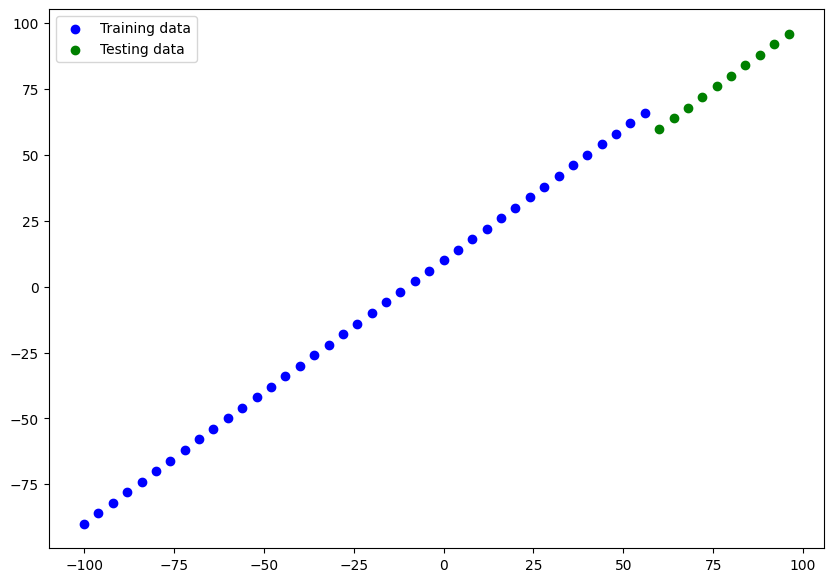

In [18]:
plt.figure(figsize=(10,7))
# Plot training data in blue
plt.scatter(X_train, y_train, c='b', label='Training data')
# Plot test data in green
plt.scatter(X_test, y_test, c='g', label='Testing data')
# show the legend
plt.legend();

In [19]:
# Set the random seed
tf.random.set_seed(42)

# Create a model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1)
    ])

model .compile(loss = tf.keras.losses.mae,
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["mae"])

# Fit the model
# model.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100) # commented out on purpose (not fitting it just yet)

## Visualizing the model

You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it

In [20]:
#model.summary() # Doesn't work (model not fit/built) try to run it by uncommenting the code

The cell above errors because we haven't fit or built our model.

We also haven't told it what input shape it should be expecting.

We can let our model know the input shape of our data using the `input_shape` parameter to the first layer (usually if `input_shape` isn't defined, Keras tries to figure it out automatically).

In [21]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[1]) # define the input_shape to our model
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.

**Total params:** The total number of parameters (weights and biases) in the model.

**Trainable params:** Parameters that the model will learn and update during training.

**Non-trainable params:** Parameters that remain fixed and are not updated during training. This can include frozen layers or certain types of layers like batch normalization.
Example: In a simple model, if a dense layer has 50 trainable parameters and another has 6, total params would be 56. If the first layer is frozen, 50 would be non-trainable, leaving 6 trainable params.

In [23]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, verbose=0) # verbose controls how much gets output

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Alongside summary, you can also view a 2D plot of the model using `plot_model()`.

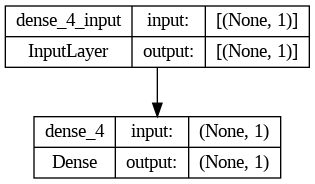

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.

To visualize predictions, it's always a good idea to plot them against the ground truth labels.

Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.

In [26]:
y_preds = model.predict(X_test)
y_preds

1/1 [==============================] - 0s 353ms/step


array([[44.353104],
       [47.2246  ],
       [50.0961  ],
       [52.967598],
       [55.839096],
       [58.710594],
       [61.582096],
       [64.4536  ],
       [67.32509 ],
       [70.196594]], dtype=float32)

In [27]:
def plot_predictions(train_data = X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=y_preds):
  """
  plots training data, test data, and compares predicitons
  """

  plt.figure(figsize=(10,7))
  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', label='Training data')
  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', label="Test data")
  # plot predictions in red
  plt.scatter(test_data, predictions, c='r', label='Predictions')
  plt.legend();

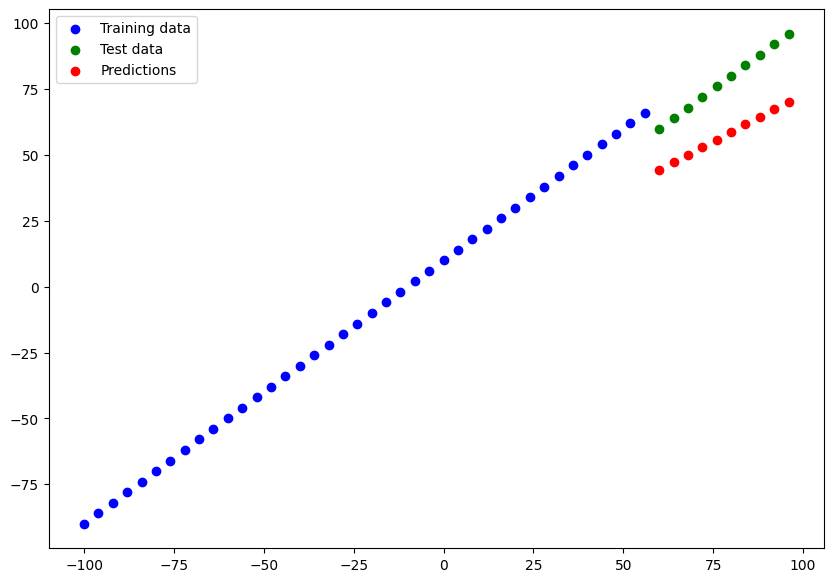

In [28]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

## Evaluating Predictions

Alongside visualizations, evaluation metrics are my best alternative for assessing my model.

Depending on the problem I'm working on, different models use different evaluation metrics.

Two of the main metrics used for regression problems are:
* **Mean Absolute Error (MAE)** - the mean difference between each of the predictions.
* **Mean Squared Error (MSE)** - the squared mean difference between the predictions (use this if larger errors are more detrimental than smaller errors).

The lower each of these values, the better.

we can also use [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate), which will return the loss of the model as well as any metrics set up during the compile step.


In [29]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 466ms/step - loss: 20.7252 - mae: 20.7252


[20.725154876708984, 20.725154876708984]

In our case, since we used MAE for the loss function as well as MAE for the metrics, `model.evaulate()` returns them both.

TensorFlow also has built in functions for MSE and MAE.

For many evaluation functions, the premise is the same: compare predictions to the ground truth labels.

In [30]:
mae = tf.metrics.mean_absolute_error(y_true=y_test,
                                    y_pred=y_preds)
mae

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33.646896, 30.775396, 27.9039  , 25.032402, 22.160904, 19.289406,
       16.734324, 14.527842, 12.804947, 11.521362], dtype=float32)>

we got 10 values, instead of 1
This is because our `y_test` and `y_preds` tensors are different shapes

In [31]:
# Check the test label tensor values
y_test

array([60, 64, 68, 72, 76, 80, 84, 88, 92, 96])

In [32]:
# Check the predictions tensor values
y_preds

array([[44.353104],
       [47.2246  ],
       [50.0961  ],
       [52.967598],
       [55.839096],
       [58.710594],
       [61.582096],
       [64.4536  ],
       [67.32509 ],
       [70.196594]], dtype=float32)

In [33]:
y_test.shape, y_preds.shape

((10,), (10, 1))

We can fix it using [`squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze), it'll remove the the `1` dimension from our `y_preds` tensor, making it the same shape as `y_test`.

In [34]:
y_preds.shape, y_preds.squeeze().shape

((10, 1), (10,))

In [35]:
y_test, y_preds.squeeze()

(array([60, 64, 68, 72, 76, 80, 84, 88, 92, 96]),
 array([44.353104, 47.2246  , 50.0961  , 52.967598, 55.839096, 58.710594,
        61.582096, 64.4536  , 67.32509 , 70.196594], dtype=float32))

In [36]:
# Calculate the mae
mae = tf.metrics.mean_absolute_error(y_true=y_test,
                                    y_pred=y_preds.squeeze())
mae

<tf.Tensor: shape=(), dtype=float32, numpy=20.725155>

In [37]:
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=y_preds.squeeze())
mse

<tf.Tensor: shape=(), dtype=float32, numpy=440.03848>

In [38]:
# Returns the same as tf.metrics.mean_absolute_error()
tf.reduce_mean(tf.abs(y_test-y_preds.squeeze()))

<tf.Tensor: shape=(), dtype=float64, numpy=20.72515296936035>

In [39]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test,
                                        y_pred)

def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.metrics.mean_squared_error(y_test,
                                       y_pred)

# Running Experiments to Improve a Model

After seeing the evaluation metrics and the predictions my model makes, I'll likely want to improve it.

There are many different ways to do this, but three of the main ones are:
1. **Get more data** - acquire more examples for the model to train on, providing more opportunities to learn patterns.
2. **Make the model larger (use a more complex model)** - this could involve adding more layers or more hidden units in each layer.
3. **Train for longer** - give the model more time to find patterns in the data.

So I'll focus on how I can improve my model using strategies 2 and 3.

To do this, I'll build three models and compare their results:
1. `model_1` - same as the original model, with 1 layer, trained for 100 epochs.
2. `model_2` - with 2 layers, trained for 100 epochs.
3. `model_3` - with 2 layers, trained for 500 epochs.

**Build `model_1`**


In [40]:
# set random seed
tf.random.set_seed(42)

# Replicate the original model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# Compile the model
model_1.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

In [41]:
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 45ms/step - loss: 51.4556 - mae: 51.4556
Epoch 2/100
2/2 [==============================] - 0s 14ms/step - loss: 18.2963 - mae: 18.2963
Epoch 3/100
2/2 [==============================] - 0s 31ms/step - loss: 10.0681 - mae: 10.0681
Epoch 4/100
2/2 [==============================] - 0s 14ms/step - loss: 9.5581 - mae: 9.5581
Epoch 5/100
2/2 [==============================] - 0s 17ms/step - loss: 10.4640 - mae: 10.4640
Epoch 6/100
2/2 [==============================] - 0s 22ms/step - loss: 9.6927 - mae: 9.6927
Epoch 7/100
2/2 [==============================] - 0s 27ms/step - loss: 8.7912 - mae: 8.7912
Epoch 8/100
2/2 [==============================] - 0s 14ms/step - loss: 9.0733 - mae: 9.0733
Epoch 9/100
2/2 [==============================] - 0s 23ms/step - loss: 19.2840 - mae: 19.2840
Epoch 10/100
2/2 [==============================] - 0s 26ms/step - loss: 10.4182 - mae: 10.4182
Epoch 11/100
2/2 [==============================] - 0s 43

1/1 [==============================] - 0s 211ms/step


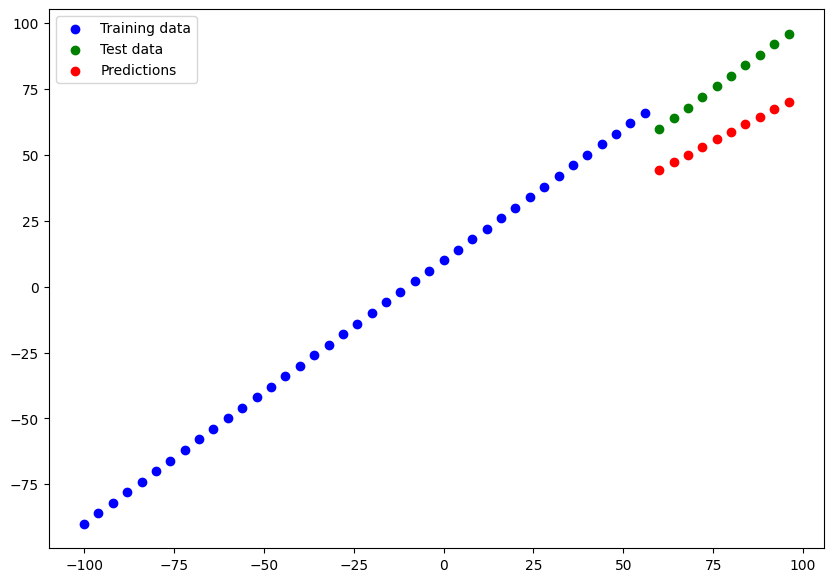

In [42]:
y_preds_1=model_1.predict(X_test)
plot_predictions(predictions=y_preds_1)

In [43]:
# Calculate mae and mse
mae_1 = mae(y_test, y_preds_1.squeeze()).numpy()
mse_1 = mse(y_test, y_preds_1.squeeze()).numpy()
mae_1, mse_1

(20.677856, 438.0501)

In [44]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

In [45]:
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100, verbose=0)

1/1 [==============================] - 0s 63ms/step


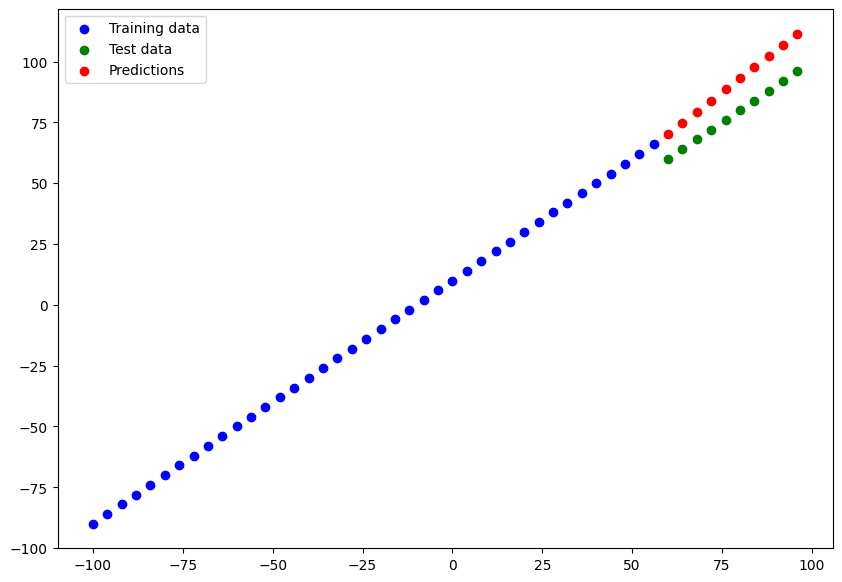

In [46]:
y_preds_2 = model_2.predict(X_test)
plot_predictions(predictions=y_preds_2)

In [47]:
y_preds_2

array([[ 70.304276],
       [ 74.87718 ],
       [ 79.45008 ],
       [ 84.02299 ],
       [ 88.5959  ],
       [ 93.16881 ],
       [ 97.74171 ],
       [102.31461 ],
       [106.88752 ],
       [111.46043 ]], dtype=float32)

In [48]:
# Calculate model_2 metrics
mae_2 = mae(y_test, y_preds_2.squeeze()).numpy()
mse_2 = mse(y_test, y_preds_2.squeeze()).numpy()
mae_2, mse_2

(12.88235, 168.66277)

In [49]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"])

model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500, verbose=0)

1/1 [==============================] - 0s 59ms/step


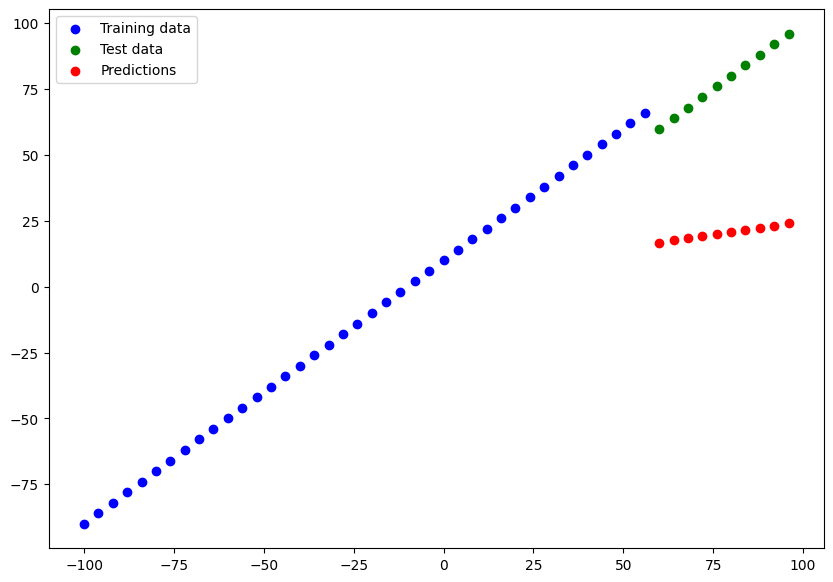

In [50]:
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

As it turns out, our model might've trained too long and has thus resulted in worse results (we'll see ways to prevent training for too long later on).

In [51]:
mae_3 = mae(y_test, tf.squeeze(y_preds_3)).numpy()
mse_3 = mse(y_test, tf.squeeze(y_preds_3)).numpy()
mae_3, mse_3

(57.612816, 3403.2612)

## Comparing results

In [52]:
model_results = [["model_1", mae_1, mse_1],
                 ["model_2", mae_2, mse_2],
                 ["model_3", mae_3, mse_3]]

In [53]:
import pandas as pd
all_results = pd.DataFrame(model_results, columns=["model", "mae","mse"])

In [54]:
all_results

,model,mae,mse
0,model_1,20.677856,438.050110
1,model_2,12.882350,168.662766
2,model_3,57.612816,3403.261230


In [55]:
list(all_results.model), list(all_results.mae), list(all_results.mse)

(['model_1', 'model_2', 'model_3'],
 [20.6778564453125, 12.882349967956543, 57.612815856933594],
 [438.05010986328125, 168.6627655029297, 3403.26123046875])

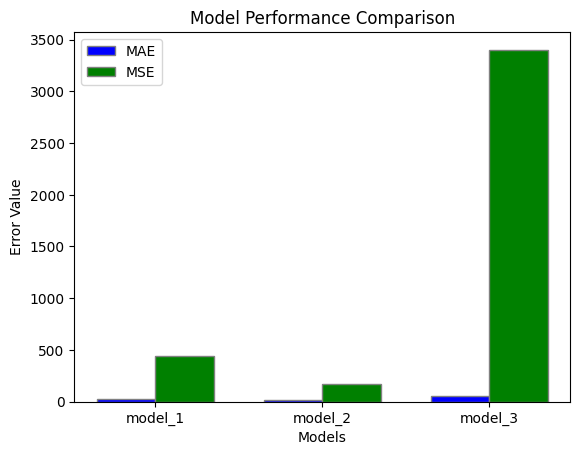

In [56]:
import matplotlib.pyplot as plt

models = list(all_results.model)
mae_values = list(all_results.mae)
mse_values = list(all_results.mse)

# Set width of bars
bar_width = 0.35

# Set position of bars on X axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, mae_values, color='b', width=bar_width, edgecolor='grey', label='MAE')
plt.bar(r2, mse_values, color='g', width=bar_width, edgecolor='grey', label='MSE')

# Add xticks on the middle of the group bars
plt.xlabel('Models')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Create legend & Show graphic
plt.ylabel('Error Value')
plt.title('Model Performance Comparison')
plt.legend();

From above experiments, it looks like `model_2` performed the best.

This is a key part of machine learning modeling: trying many different combinations of models and seeing which one performs best.

Each model we build is a small experiment.

# Tracking Experiments

> 📖 **Resource:** As we build more models, we should also look into using tools such as:
* [**TensorBoard**](https://tensorboard.dev/) - a component of the TensorFlow library to help track modeling experiments.
* [**Weights & Biases**](https://www.wandb.com/) - a tool for tracking all kinds of machine learning experiments (good news is that Weights & Biases integrates with TensorBoard).


# Saving our models

Saving models is a critical part of the machine learning workflow. It ensures that the trained model can be reused, shared, and deployed without having to retrain it from scratch.

There are two main formats we can save our model's:
1. The SavedModel format.
2. The HDF5 format.

In [57]:
# Saving model using the SavedModel format
model_2.save("Best_model_SavedModel_format")

In [58]:
# Saving model using the HDF5 format
model_2.save("Best_model_HDF5_format")

# Loading our saved models

we can load the saved models using `tf.keras.models.load_model` method.

In [59]:
# Loading the 'SavedModel' format model
load_SavedModel = tf.keras.models.load_model('/content/Best_model_SavedModel_format')

In [60]:
load_SavedModel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Compare model_2 predictions with SavedModel format model predictions
model_2_preds = model_2.predict(X_test)
loaded_SavedModel_format_preds = load_SavedModel.predict(X_test)
model_2_preds == loaded_SavedModel_format_preds

1/1 [==============================] - 0s 58ms/step


array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [62]:
# Compare the mae of model_2_preds with SavedModel format model preds
mae(y_test, model_2_preds) == mae(y_test, loaded_SavedModel_format_preds)

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])>

In [63]:
# Load HDF5 format model
load_HDF5 = tf.keras.models.load_model("/content/Best_model_HDF5_format")
load_HDF5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Compare model_2 predictions with HDF5 format model predictions
loaded_HDF5_preds = load_HDF5.predict(X_test)
model_2_preds == loaded_HDF5_preds

1/1 [==============================] - 0s 66ms/step


array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [65]:
# Compare the mae of model_2_preds with HDF5 format model preds
mae(y_test, model_2_preds) == mae(y_test, loaded_HDF5_preds)

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])>

# Download a model/files from Google Colab

if we want to download files from Google Colab:
1. we can go to "files" tab and right click on the file that we want and click "download".
2. By using the code.
3. Save it to Google Drive by connecting Google Drive and copying it there.

In [66]:
import os
# Specify the file path
file_path = "/content/Best_model_HDF5_format"

# Check if the file exists
if os.path.exists(file_path):
    # Get the file size
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size} bytes")
else:
    print("File not found!")


File size: 4096 bytes


In [67]:
# Download a file from Google Colab using code
from google.colab import files
files.download("/content/Best_model_HDF5_format")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Save a file from Google Colab to Google Drive (requires mounting drive)
!cp -r /content/Best_model_SavedModel_format /content/saved_models

In [69]:
!ls /content/saved_models

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


# A larger example

In [70]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

Dataset: [Insurance.csv](https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv).

In [71]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [72]:
# Convert categorical data into numbers
insurance_one_hot = pd.get_dummies(insurance, dtype=int)
insurance_one_hot.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [73]:
# Create X and y values (features and labels)
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

# shape of X and y
X.shape, y.shape

((1338, 11), (1338,))

In [74]:
# splitting data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 11), (268, 11), (1070,), (268,))

In [75]:
# set random seed
tf.random.set_seed(42)

# Create a Sequential model
model_insurance = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# compile the model
model_insurance.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# fit training and test sets
model_insurance.fit(X_train, y_train, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 3ms/step - loss: 8615.8135 - mae: 8615.8135
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 7877.3540 - mae: 7877.3540
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 7512.6519 - mae: 7512.6519
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 7771.7002 - mae: 7771.7002
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 7691.5645 - mae: 7691.5645
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 7642.7554 - mae: 7642.7554
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 7505.1646 - mae: 7505.1646
Epoch 8/100
34/34 [==============================] - 0s 6ms/step - loss: 7689.4492 - mae: 7689.4492
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 7453.9126 - mae: 7453.9126
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 7648.6724 - mae: 7648.6724

In [76]:
# check the results of the insurance model on the test data
model_insurance.evaluate(X_test, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 8727.6006 - mae: 8727.6006


[8727.6005859375, 8727.6005859375]

So our model isn't performing well, let's try to improve it!

In [77]:
# set random seed
tf.random.set_seed(42)

# Create a Sequential model
model_insurance2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# compile the model
model_insurance2.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=["mae"])

# fit training and test sets
insurance_model_history = model_insurance2.fit(X_train, y_train, epochs=200, verbose=0)

In [78]:
model_insurance2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 2922.1826 - mae: 2922.1826


[2922.1826171875, 2922.1826171875]

Much better when compared to previous model.

> 🔑 **Note:** The [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) is a great starting choice. See Andrei Karpathy's "Adam is safe" point from [*A Recipe for Training Neural Networks*](http://karpathy.github.io/2019/04/25/recipe/) for more.

Let's check out the loss curves of our model, we should see a downward trend.

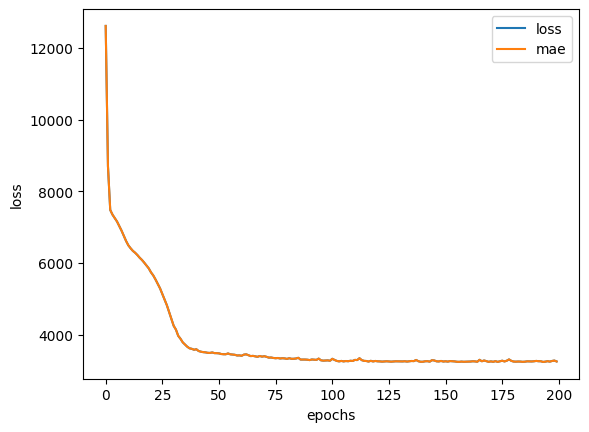

In [79]:
# plot history (also known as loss curve)
pd.DataFrame(insurance_model_history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

From this, it looks like our model's loss (and MAE) were both still decreasing (in our case, MAE and loss are the same, hence the lines in the plot overlap eachother).

What this tells us is the loss might go down if we try training it for longer.

> 🤔 **Question:** How long should you train for?

> It depends on what problem we're working on. Sometimes training won't take very long, other times it'll take longer than we expect. A common method is to set your model training for a very long time (e.g. 1000's of epochs) but set it up with an [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) so it stops automatically when it stops improving.

Let's train the same model as above for a little longer. We can do this but calling fit on it again.

In [80]:
history_2 = model_insurance2.fit(X_train, y_train, epochs=100, verbose=0)

In [81]:
# Evaluate the model trained for 200 total epochs
model_insurance2_loss, model_insurance2_mae = model_insurance2.evaluate(X_test, y_test)
model_insurance2_loss, model_insurance2_mae

9/9 [==============================] - 0s 2ms/step - loss: 2893.0132 - mae: 2893.0132


(2893.01318359375, 2893.01318359375)

 Training for an extra 100 epochs we see about a 10% decrease in error.

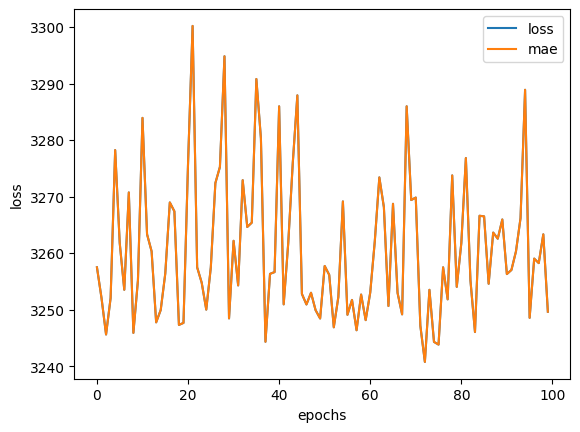

In [82]:
# plot history (also known as loss curve)
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

# Preprocessing data (normalization and Standardization)

A common practice when working with neural networks is to make sure all of the data we pass to them is in the range of 0 to 1.

This practice is called **normalization** (scaling all values from their original range, such as between 0 and 100,000, to be between 0 and 1).

There is another process called **standardization**, which converts all of the data to unit variance and a mean of 0.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare data for use with neural networks).

Knowing this, some of the major steps we'll take to preprocess data for a neural network include:
* Turning all data into numbers (a neural network can't handle strings).
* Making sure data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value and then dividing by the maximum value minus the minimum. This is also referred to as min-max scaling.
    * Standardizing data (making sure all values have a mean of 0 and a variance of 1). This is done by subtracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should we use?
      * **With neural networks, we should tend to favor normalization** as they usually perform better with values between 0 and 1 (this is especially true with image processing). However, neural networks can often perform well with minimal feature scaling.

> 📖 **Resource:** For more on preprocessing data, reading the following resources:
* [Scikit-Learn's documentation on preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize or Normalize with Scikit-Learn by Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

We've already turned data into numbers using `get_dummies()`, now we'll see how to normalize it as well.


In [83]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Read the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [84]:
# check out the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [85]:
# preprocessing using sklearn
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

ct = make_column_transformer(
    (MinMaxScaler(), ["age","bmi","children"]), # get all the values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ['sex','smoker','region'])
)

# Create X and y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our training and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding(OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Now we've normalized it and one-hot encoding it, what does our data look like now?

In [86]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [87]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

In [88]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Our data is normalized and numerical, let's model it.

Lets, create a `model_insurance3`.

In [89]:
# set random seed
tf.random.set_seed(42)

# Create a Sequential model
model_insurance3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1)
])

# compile the model
model_insurance3.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=["mae"])

# fit training and test sets
model_insurance3.fit(X_train_normal, y_train, epochs=200, verbose=0)

In [90]:
# Evaluate 3rd model
model_insurance3_loss, model_insurance3_mae = model_insurance3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 2006.5420 - mae: 2006.5420


we can see some improvement in our predictions.

This is **one of the main benefits of normalization: faster convergence time** (a fancy way of saying, your model gets to better results faster).

the results may change if we were to alter the architectures of the models, e.g. more hidden units per layer or more layers.

But since our main goal as neural network practitioners is to decrease the time between experiments, anything that helps us get better results sooner is a plus.